<a href="https://colab.research.google.com/github/alepenaa94/TP1_Real_or_Not/blob/master/TP1_Real_or_Not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABAJO PRÁCTICO 1: Análisis Exploratorio de Datos

## Análisis realizado
- [Análisis del campo keyword](#link_2)
- [Análisis del campo location](#link_3)
- [Análisis de la cantidad de palabras de los tweets](#link_4)
- [Análisis de la longitud de los tweets](#link_5)
- [Covarianza y Correlación](#link_6)
- [Análisis de menciones](#link_7)
- [Análisis de "tweets expresivos"](#link_8)
- [Análisis de registros en donde el text no contenga la keyword](#link_9)
- [Análisis de hashtags](#link_10)
- [Análisis de links](#link_11)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 10)
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
train_df = pd.read_csv('./Data/train.csv', encoding='latin-1',dtype={'id': np.uint16,'target': np.bool})

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True


Para dar un primer vistazo a la información con la que vamos trabajar, veamos rápidamente cómo está distribuída la cantidad de tweets según si son verdaderos o falsos.

In [4]:
train_df['target'].value_counts()

False    4342
True     3271
Name: target, dtype: int64

Podemos ver que casi el %43 de los tweets describen realmente un desastre en texto.

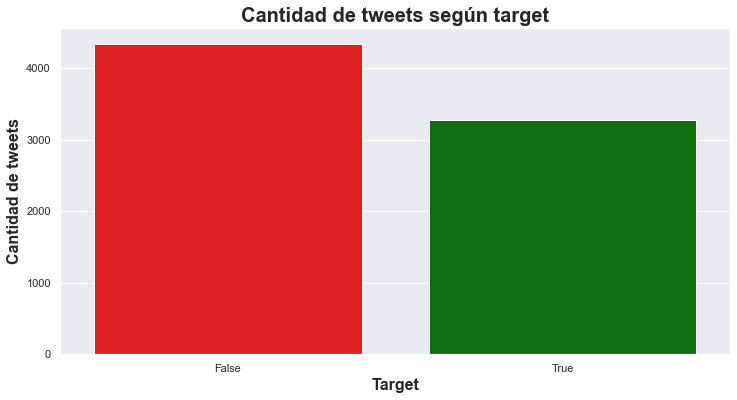

In [5]:
plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = train_df,palette=['red','green']);

plt.title('Cantidad de tweets según target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

plt.show()

Vamos a ver la información del dataframe para analizar los campos que tienen valores nulos.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null uint16
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null bool
dtypes: bool(1), object(3), uint16(1)
memory usage: 200.9+ KB


Podemos observar que las columnas **"keyword"** y **"location"** poseen algunos valores nulos, vamos a analizar cada caso particular para determinar como vamos a proceder con los análisis.

## Análisis del campo keyword<a id='link_2'></a>

In [7]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

El campo **keyword** tiene **61 registros** con valores nulos. Como es una cantidad pequeña en relación a la cantidad total de registros (**7613 registros**), para los análisis vamos a considerar descartar los registros nulos.

Veamos que tipo de valores contiene este campo.

In [8]:
train_df['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
harm                     41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
train_df.loc[~train_df['keyword'].isnull() & train_df['keyword'].str.contains('%20')]['keyword'].value_counts()

body%20bags              41
oil%20spill              38
burning%20buildings      37
nuclear%20reactor        36
dust%20storm             36
cliff%20fall             36
buildings%20burning      35
emergency%20plan         35
bridge%20collapse        35
structural%20failure     35
suicide%20bomb           35
airplane%20accident      35
nuclear%20disaster       34
loud%20bang              34
natural%20disaster       34
heat%20wave              34
emergency%20services     33
fire%20truck             33
blown%20up               33
mass%20murder            33
body%20bagging           33
violent%20storm          33
blew%20up                33
chemical%20emergency     33
suicide%20bombing        33
body%20bag               33
buildings%20on%20fire    33
mass%20murderer          32
forest%20fires           32
wild%20fires             31
suicide%20bomber         31
first%20responders       29
bush%20fires             25
war%20zone               24
forest%20fire            19
radiation%20emergenc

Observamos que en algunos keyword aparece "%20" en donde va un espacio; vamos a limpiar esto para mayor claridad en la información.

In [10]:
train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')

Veamos cuales son las 20 keywords más frecuentes.

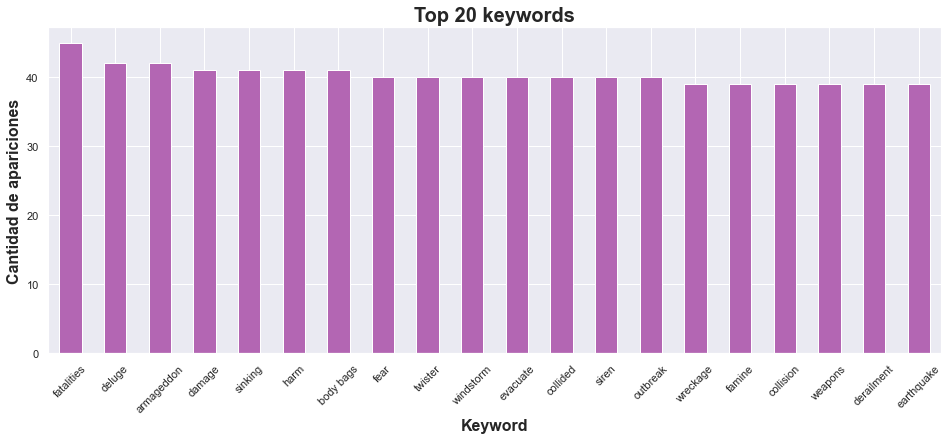

In [11]:
plot = train_df['keyword'].value_counts()[0:20].plot(kind='bar',figsize=(16,6), color=(0.7,0.4,0.7))

plot.set_title('Top 20 keywords', fontsize=20,weight='bold');
plot.set_xlabel('Keyword', fontsize=16,weight='bold')
plot.set_ylabel('Cantidad de apariciones', fontsize=16,weight='bold')

plt.xticks(rotation=45);

Veamos como se comportan los keywords en la apertura true/false.

In [12]:
keywords_verdaderos = train_df.loc[~train_df['keyword'].isnull() & train_df['target']]['keyword']
keywords_verdaderos.value_counts()

outbreak       39
wreckage       39
derailment     39
debris         37
typhoon        37
               ..
electrocute     1
ruin            1
body bags       1
epicentre       1
blazing         1
Name: keyword, Length: 220, dtype: int64

In [13]:
keywords_verdaderos.describe()

count         3229
unique         220
top       outbreak
freq            39
Name: keyword, dtype: object

In [14]:
keywords_falsos = train_df.loc[~train_df['keyword'].isnull() & ~train_df['target']]['keyword']
keywords_falsos.value_counts()

body bags          40
harm               37
armageddon         37
wrecked            36
deluge             36
                   ..
typhoon             1
suicide bombing     1
oil spill           1
suicide bomber      1
outbreak            1
Name: keyword, Length: 218, dtype: int64

In [15]:
keywords_falsos.describe()

count          4323
unique          218
top       body bags
freq             40
Name: keyword, dtype: object

Observamos que la mayoría de los keywords aparecen en ambos, solo 4 valores aparecen en uno y no en el otro. Así como también observamos que la frecuencia es similar.

In [16]:
df1 = keywords_verdaderos.value_counts().to_frame().reset_index()
df1.columns = ['keyword','count']

df2 = keywords_falsos.value_counts().to_frame().reset_index()
df2.columns = ['keyword','count']

merge_keywords = pd.merge(df1,df2,how='outer',on='keyword')
merge_keywords.head()

,keyword,count_x,count_y
0,outbreak,39.0,1.0
1,wreckage,39.0,NaN
2,derailment,39.0,NaN
3,debris,37.0,NaN
4,typhoon,37.0,1.0


In [17]:
merge_keywords.fillna(value=0,inplace=True)

In [18]:
merge_keywords.rename(columns={'count_x':'cantidad_verdaderos','count_y':'cantidad_falsos'},inplace=True)

In [19]:
merge_keywords.head()

,keyword,cantidad_verdaderos,cantidad_falsos
0,outbreak,39.0,1.0
1,wreckage,39.0,0.0
2,derailment,39.0,0.0
3,debris,37.0,0.0
4,typhoon,37.0,1.0


In [20]:
merge_keywords.describe()

,cantidad_verdaderos,cantidad_falsos
count,221.000000,221.000000
mean,14.610860,19.561086
std,9.696891,9.699209
min,0.000000,0.000000
25%,6.000000,12.000000
50%,13.000000,20.000000
75%,22.000000,28.000000
max,39.000000,40.000000


Observamos que la cantidad de valores y el rango son similares, mientras que la concentración de repeticiones entre el 25% y el 75% es menor en los keywords verdaderos.

Veamos los valores que que solo aparecen en true o en false.

In [21]:
merge_keywords[merge_keywords['cantidad_falsos'] == 0]

,keyword,cantidad_verdaderos,cantidad_falsos
1,wreckage,39.0,0.0
2,derailment,39.0,0.0
3,debris,37.0,0.0


In [22]:
merge_keywords[merge_keywords['cantidad_verdaderos'] == 0]

,keyword,cantidad_verdaderos,cantidad_falsos
220,aftershock,0.0,34.0


Vemos que estás cuatro keywords son importantes para definir veracidad, ya que tienen una gran cantidad de repetiiones y están en un solo conjunto.

In [23]:
merge_keywords['porcentaje_verdaderos'] = (merge_keywords['cantidad_verdaderos'] / (merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos'])) * 100

In [24]:
merge_keywords.set_index('keyword',inplace=True)

In [25]:
merge_keywords.head()

,cantidad_verdaderos,cantidad_falsos,porcentaje_verdaderos
keyword,,,
outbreak,39.0,1.0,97.500000
wreckage,39.0,0.0,100.000000
derailment,39.0,0.0,100.000000
debris,37.0,0.0,100.000000
typhoon,37.0,1.0,97.368421


Vamos a analizar los keyword en función del porcentaje de tweets verdaderos. Para ello, vamos a considerar como significativos los keywords que tengan por lo menos 30 tweets.

Veamos los 10 keyword con mayor porcentaje de tweets verdaderos.

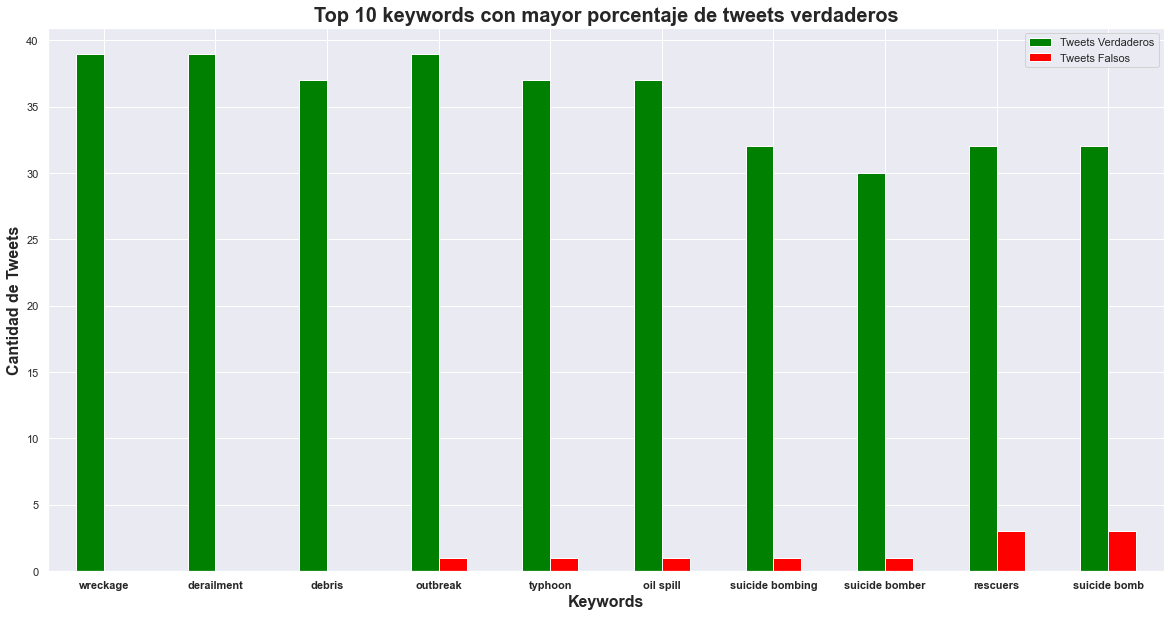

In [26]:
df_aux = merge_keywords.loc[(merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos']) > 30].nlargest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0,weight='bold')

plt.title('Top 10 keywords con mayor porcentaje de tweets verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

Ahora veamos los 10 keywords con el menor porcentaje de tweets verdaderos siguiendo el mismo criterio de antes.

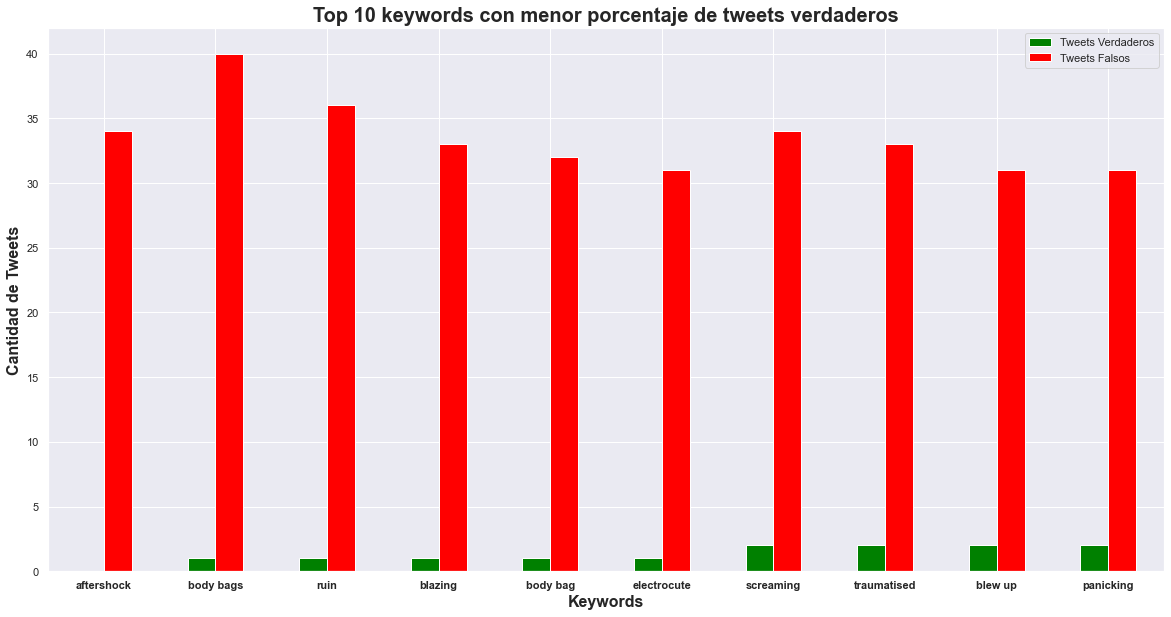

In [27]:
df_aux = merge_keywords.loc[(merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos']) > 30].nsmallest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0,weight='bold')

plt.title('Top 10 keywords con menor porcentaje de tweets verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

Finalmente, vemos los keywords que tienen una cantidad similar de tweets verdaderos y falsos.

In [28]:
porcentajes_parecidos = (merge_keywords['porcentaje_verdaderos']>=48) & (merge_keywords['porcentaje_verdaderos']<=52)

merge_parecidos = merge_keywords[porcentajes_parecidos]
merge_parecidos

,cantidad_verdaderos,cantidad_falsos,porcentaje_verdaderos
keyword,,,
explosion,20.0,19.0,51.282051
bombed,19.0,19.0,50.000000
storm,18.0,17.0,51.428571
hail,18.0,17.0,51.428571
lightning,17.0,16.0,51.515152
derail,17.0,18.0,48.571429
rescued,17.0,18.0,48.571429
hijack,16.0,17.0,48.484848
hostage,15.0,16.0,48.387097


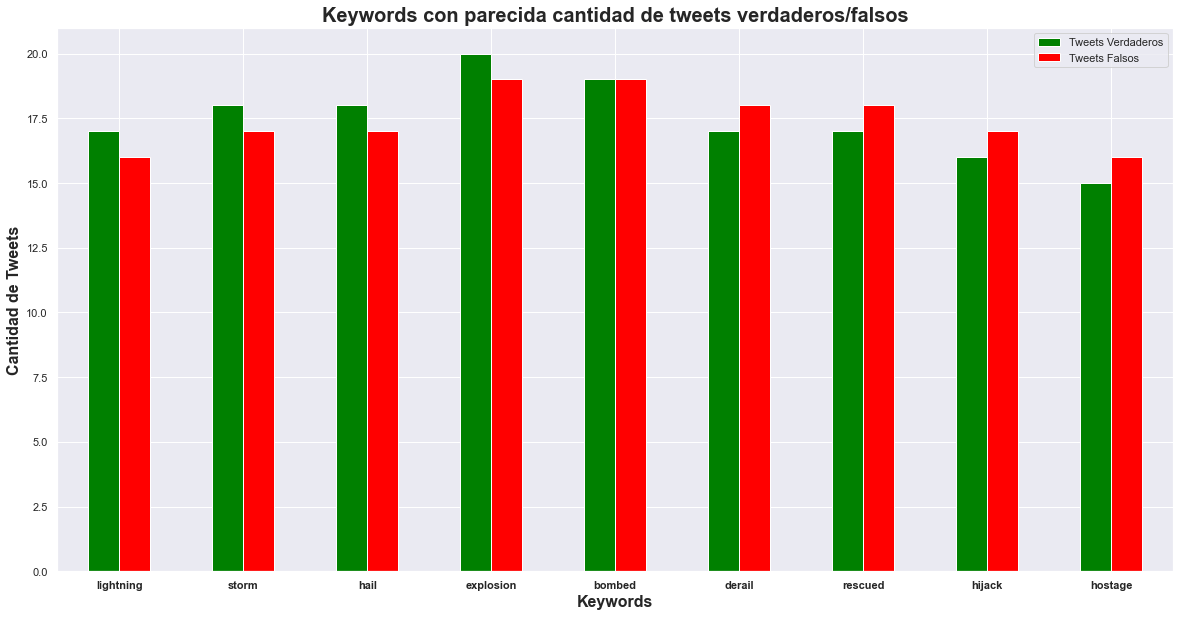

In [29]:
df_aux = merge_parecidos.loc[(porcentajes_parecidos)].nlargest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0,weight='bold')

plt.title('Keywords con parecida cantidad de tweets verdaderos/falsos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

Vamos a analizar en mayor profundidad el comportamiento de los keyword en función a sus ocurrencias en tweets.

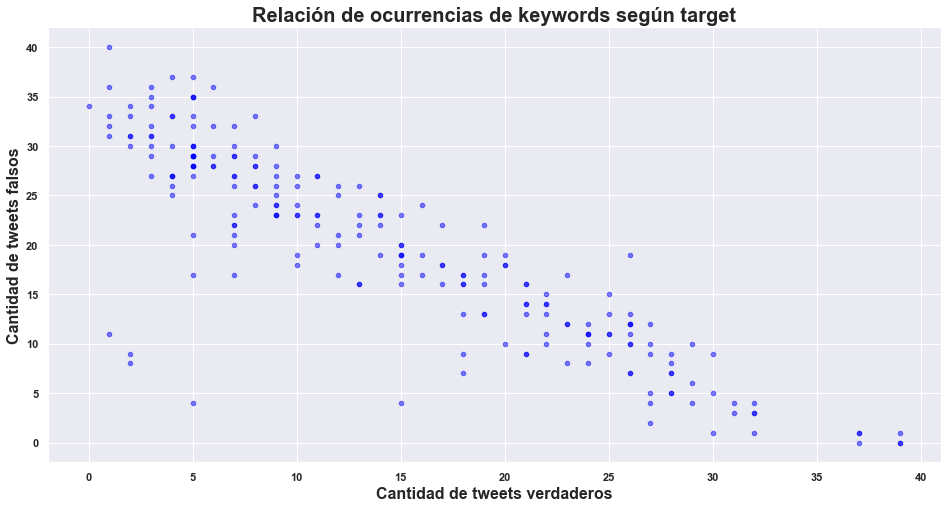

In [30]:
merge_keywords.plot.scatter('cantidad_verdaderos','cantidad_falsos',c='Blue',alpha=0.5,figsize=(16,8))
ax=plt.gca()

plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.title('Relación de ocurrencias de keywords según target', fontsize=20,weight='bold')
plt.ylabel('Cantidad de tweets falsos', fontsize=16,weight='bold')
plt.xlabel('Cantidad de tweets verdaderos', fontsize=16,weight='bold');

Podemos observar que a medida que aumenta la cantidad de tweets verdaderos en una keyword, disminuye la cantidad de tweets falsos y viceversa.

## Análisis del campo location<a id='link_3'></a>

In [31]:
train_df['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [32]:
train_df['location'].sample(30)

3447         South east of U.K
7222                       NaN
5697               Leeds, U.K.
407                        NaN
2451                       NaN
5246                  Amarillo
7180             BROOKLYN, NYC
6771                          
4525                       NYC
3735                  New York
3257                California
2246                       NaN
100                         UK
3095             Cairo, Egypt.
1829                       NaN
507                        NaN
4201                     Kenya
2796      Philadelphia, PA USA
5634                       NaN
1018             Austin, Texas
2307                    Canada
5615          Aurora, Ontario 
5325                  Scotland
1843    Viterbo BFA Acting '18
7380                calgary,ab
6981            Las Vegas, NV 
4946             Cleveland, OH
6763                       NaN
5100    Sacramento, California
5956                       NaN
Name: location, dtype: object

Como habíamos visto previamente, este campo tiene muchos valores nulos. Como no es una cantidad despreciable como en el caso de las keywords, vamos a completar los valores nulos con el texto "Unknown".

In [33]:
train_df['location'].fillna('Unknown',inplace=True)

Se observa que la ubicacion ingresada no es siempre algo coherente. Veamos las ubicaciónes no nulas con mayor cantidad de tweets.

In [34]:
locations_count = train_df.loc[train_df['location'] != 'Unknown']['location'].value_counts()
locations_count

USA                       104
New York                   71
United States              50
London                     45
Canada                     29
                         ... 
Ukraine and Ireland         1
UK Great Britain            1
Kutztown, PA                1
London/Outlaw Country       1
dundalk ireland             1
Name: location, Length: 3340, dtype: int64

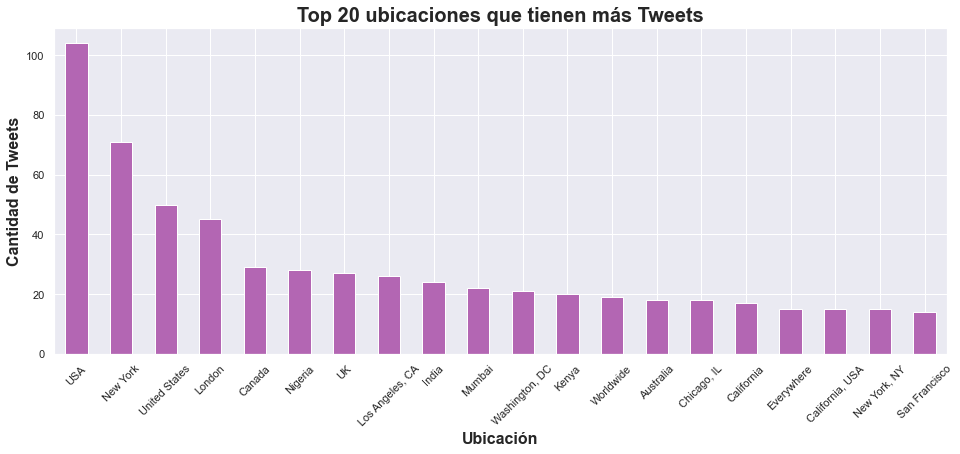

In [35]:
plot = train_df.loc[train_df['location'] != 'Unknown']['location'].value_counts()[0:20].plot(kind='bar',figsize=(16,6), color=(0.7,0.4,0.7))

plot.set_title('Top 20 ubicaciones que tienen más Tweets', fontsize=20,weight='bold');
plot.set_xlabel('Ubicación', fontsize=16,weight='bold')
plot.set_ylabel('Cantidad de Tweets', fontsize=16,weight='bold')

plt.xticks(rotation=45);

Veamos las ubicaciones que tienen un único tweet.

In [36]:
location_with_one_tweet = locations_count[locations_count == 1]
location_with_one_tweet.sample(15)

Konoha                          1
Harlem, NY or Chocolate City    1
toronto                         1
WORDLDWIDE                      1
Williamsburg, VA                1
california                      1
Warszawa                        1
Idaho                           1
Dublin                          1
Walthamstow, London             1
-?s?s?j??s-                     1
Fort Knox, KY 40121             1
Greenpoint                      1
death star                      1
Ventura                         1
Name: location, dtype: int64

In [37]:
print("Ubicaciones con un único tweet:",location_with_one_tweet.count());
print("Ubicaciones diferentes:",len(train_df['location'].unique()))
print("Porcentaje de ubicaciones que solo aparecen 1 vez:",location_with_one_tweet.count()/len(train_df['location'].unique())*100)

Ubicaciones con un único tweet: 2818
Ubicaciones diferentes: 3341
Porcentaje de ubicaciones que solo aparecen 1 vez: 84.34600419036217


Aproximadamente el 84,3% de las ubicaciones tienen un sólo tweet. ¿Cuántas de esas corresponden a tweets falsos?

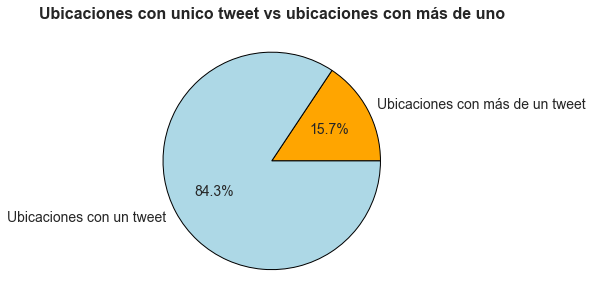

In [38]:
total = len(train_df['location'].unique())
unicos = location_with_one_tweet.count()

slices = [total-unicos,unicos]
m_labels = ['Ubicaciones con más de un tweet','Ubicaciones con un tweet']
m_colors = ['orange','lightblue']

plt.figure(figsize=(5,5))
plt.pie(slices,labels=m_labels,colors = m_colors,autopct ='%1.1f%%', wedgeprops={'edgecolor':'black'},textprops={'fontsize': 14})

plt.title("Ubicaciones con unico tweet vs ubicaciones con más de uno",fontsize=16,weight='bold')
plt.show()

In [39]:
tweets_one_location = train_df.groupby("location").filter(lambda x: len(x) == 1)
tweets_one_location.head()

,id,keyword,location,text,target
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,False
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,True
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,True
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,False
42,62,ablaze,milky way,Had an awesome time visiting the CFC head offi...,False


In [40]:
tweets_one_location['target'].value_counts()

False    1716
True     1102
Name: target, dtype: int64

Vemos que aproximadamente, de estos tweets, el 60,9% resultan ser falsos.

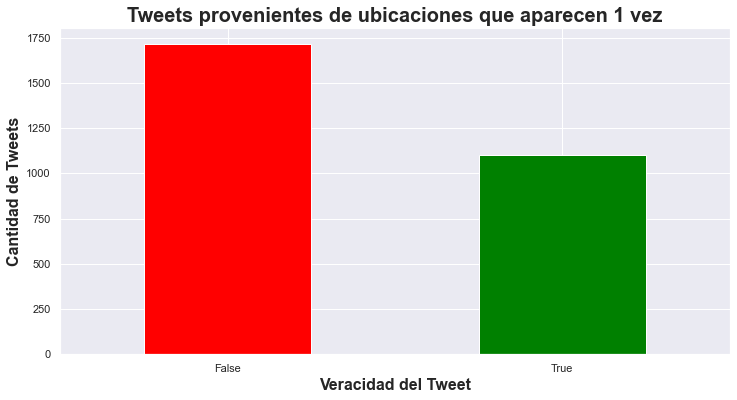

In [41]:
tweets_one_location['target'].value_counts().plot.bar(figsize=(12,6), color=('red','green'));
plt.xticks(rotation=0)

plt.title('Tweets provenientes de ubicaciones que aparecen 1 vez', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');
plt.xlabel('Veracidad del Tweet', fontsize=16,weight='bold');

In [42]:
train_df['target'].value_counts()

False    4342
True     3271
Name: target, dtype: int64

En relacion a todos los registros, representa el 39,5% de los tweets falsos, y casi 33,7% de los verdaderos.

Veamos ahora considerando también los casos en donde la ubicación es desconocida.

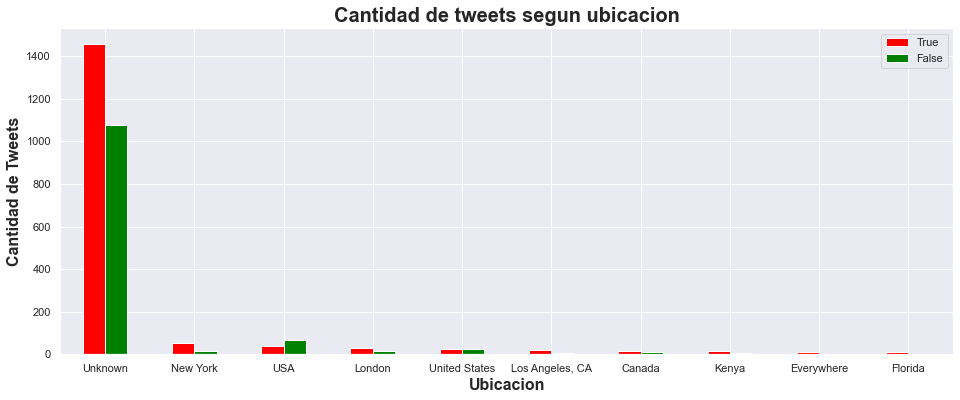

In [43]:
df = train_df
df = df[['location','target','id']].groupby(['location','target']).count().unstack().fillna(0)
df.columns=['True','False']
df.sort_values(by='True',ascending=False,inplace=True)

df.head(10).plot.bar(figsize=(16,6), color=('red','green'));
plt.xticks(rotation=0)

plt.title('Cantidad de tweets segun ubicacion', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');
plt.xlabel('Ubicacion', fontsize=16,weight='bold');

Analicemos más a fondo como se comportan las ubicaciones en la apertura true/false.

In [44]:
locations_verdaderos = train_df.loc[(train_df['location'] != 'Unknown') & (train_df['target'])]['location']
locations_verdaderos.value_counts()

USA                       67
United States             27
Nigeria                   22
India                     20
Mumbai                    19
                          ..
portland, oregon           1
Carol Stream, Illinois     1
Honolulu, Hawaii           1
Tema,Accra                 1
Watertown, Mass.           1
Name: location, Length: 1512, dtype: int64

In [45]:
locations_verdaderos.describe()

count     2195
unique    1512
top        USA
freq        67
Name: location, dtype: object

In [46]:
locations_falsos = train_df.loc[(train_df['location'] != 'Unknown') & ~train_df['target']]['location']
locations_falsos.value_counts()

New York                     55
USA                          37
London                       29
United States                23
Los Angeles, CA              18
                             ..
DMV                           1
College Station, TX           1
Semarang, Indonesia           1
where the wild things are     1
CT & NY                       1
Name: location, Length: 2141, dtype: int64

In [47]:
locations_falsos.describe()

count         2883
unique        2141
top       New York
freq            55
Name: location, dtype: object

In [48]:
print("Ubicaciones diferentes:",len(train_df['location'].unique()))
print("Ubicaciones diferentes en tweets verdaderos:",len(locations_verdaderos.unique()))
print("Ubicaciones diferentes en tweets falsos:",len(locations_falsos.unique()))

Ubicaciones diferentes: 3341
Ubicaciones diferentes en tweets verdaderos: 1512
Ubicaciones diferentes en tweets falsos: 2141


Observamos que en su mayoria las location en true y en false son diferentes. De los **3341** valores únicos del campo, menos del 10% (**314** valores) de location aparecen en ambos tipos de tweets.

Veamos los location que aparecen tanto en tweets verdaderos como falsos.

In [49]:
df1 = locations_verdaderos.value_counts().to_frame().reset_index()
df1.columns = ['location','count']

df2 = locations_falsos.value_counts().to_frame().reset_index()
df2.columns = ['location','count']

merge_locations = pd.merge(df1,df2,how='outer',on='location')
merge_locations.head()

,location,count_x,count_y
0,USA,67.0,37.0
1,United States,27.0,23.0
2,Nigeria,22.0,6.0
3,India,20.0,4.0
4,Mumbai,19.0,3.0


In [50]:
merge_locations.rename(columns={'count_x':'cantidad_verdaderos','count_y':'cantidad_falsos'},inplace=True)

In [51]:
merge_locations.describe()

,cantidad_verdaderos,cantidad_falsos
count,1512.000000,2141.000000
mean,1.451720,1.346567
std,2.359833,1.948501
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,67.000000,55.000000


Como habíamos analizado previamente, podemos volver a observar que en su gran mayoría las locations aparecen solo una vez.

Ahora veamos que ocurre en cada conjunto: ubicaciones que aparecen solo en tweets verdaderos, solo en tweets falsos y en ambos tipos de tweets.

In [52]:
merge_locations.fillna(value=0,inplace=True)

In [53]:
merge_locations.loc[merge_locations['cantidad_falsos'] == 0]['cantidad_verdaderos'].value_counts()

1.0    1102
2.0      74
3.0      12
4.0      11
Name: cantidad_verdaderos, dtype: int64

In [54]:
merge_locations.loc[(merge_locations['cantidad_falsos'] == 0) & (merge_locations['cantidad_verdaderos'] == 4)][['location','cantidad_verdaderos']]

,location,cantidad_verdaderos
37,"Portland, Oregon",4.0
41,Nigeria,4.0
42,Nairobi-KENYA,4.0
46,canada,4.0
48,MAD as Hell,4.0
51,Jakarta/Kuala Lumpur/S'pore,4.0
52,Midwest,4.0
54,"Haddonfield, NJ",4.0
55,Sacramento,4.0
57,Calgary,4.0


Se observa que la cantidad de tweets por ubicacion se concentran en 1, y a su vez tampoco existen ubicaciones con muchos tweets, siendo el máximo 4 tweets. Esto no nos ayuda mucho porque aunque son valores que solo aparecen en true, no suman mucho peso por la baja cantidad de repeticiones.

In [55]:
merge_locations.loc[merge_locations['cantidad_verdaderos'] == 0]['cantidad_falsos'].value_counts()

1.0    1716
2.0      81
3.0      19
5.0       5
4.0       4
6.0       1
7.0       1
9.0       1
Name: cantidad_falsos, dtype: int64

In [56]:
merge_locations.loc[(merge_locations['cantidad_verdaderos'] == 0) & (merge_locations['cantidad_falsos'] > 3)][['location','cantidad_falsos']]

,location,cantidad_falsos
1512,304,9.0
1513,"Pennsylvania, USA",7.0
1514,"Morioh, Japan",6.0
1515,Coventry,5.0
1516,Wisconsin,5.0
1517,Indiana,5.0
1518,"Texas, USA",5.0
1519,"Leeds, England",5.0
1520,Edinburgh,4.0
1521,Switzerland,4.0


Se observa un comportamiento similar al caso anterior pero aquí se puede ver que existen algunas ubicaciones con mayor cantidad de tweets que en el caso de las ubicaciones de tweets solo verdaderos.

Analicemos el caso de las ubicaciones con tweets tanto verdaderos como falsos.

In [57]:
merge_locations.loc[(merge_locations['cantidad_verdaderos'] != 0) & (merge_locations['cantidad_falsos'] != 0)].describe()

,cantidad_verdaderos,cantidad_falsos
count,313.000000,313.000000
mean,2.763578,2.827476
std,4.912212,4.715864
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,67.000000,55.000000


Se observa que los datos estadísticos son similares para ambos target.

In [58]:
merge_locations.loc[(merge_locations['cantidad_verdaderos'] != 0) & (merge_locations['cantidad_falsos'] != 0)]\
                ['cantidad_verdaderos'].value_counts()

1.0     166
2.0      63
3.0      31
4.0      16
5.0       7
7.0       7
6.0       5
8.0       4
9.0       3
16.0      3
20.0      1
27.0      1
22.0      1
12.0      1
19.0      1
15.0      1
13.0      1
67.0      1
Name: cantidad_verdaderos, dtype: int64

In [59]:
merge_locations.loc[(merge_locations['cantidad_verdaderos'] != 0) & (merge_locations['cantidad_falsos'] != 0)]\
                ['cantidad_falsos'].value_counts()

1.0     163
2.0      61
3.0      29
4.0      20
5.0       8
6.0       7
7.0       6
9.0       4
10.0      3
11.0      2
8.0       2
23.0      1
12.0      1
29.0      1
55.0      1
16.0      1
15.0      1
18.0      1
37.0      1
Name: cantidad_falsos, dtype: int64

Al igual que con los datos estadísticos, la cantidad de tweets también tiene un comportamiento similar en ambos casos.

Veamos la relación entre la cantidad de tweets en cada target por ubicación.

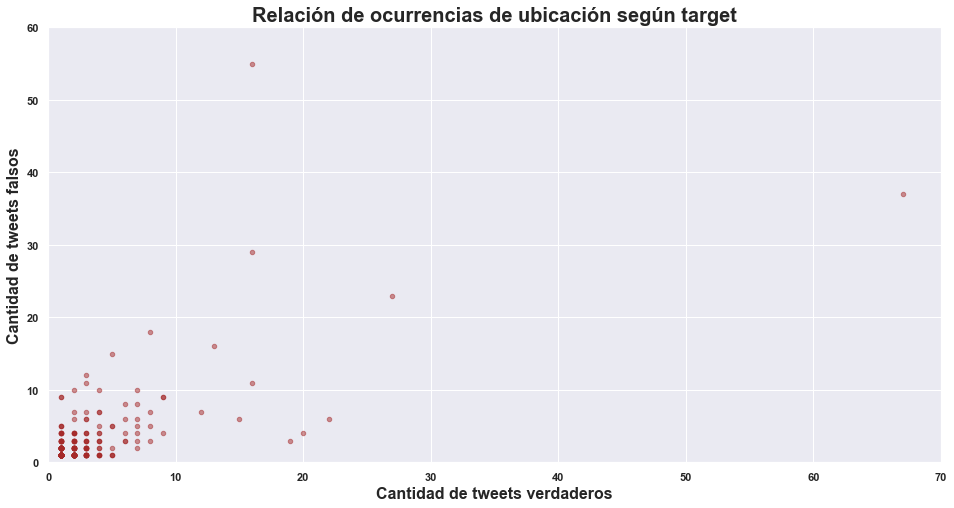

In [60]:
merge_locations.loc[(merge_locations['cantidad_verdaderos'] != 0) & (merge_locations['cantidad_falsos'] != 0)]\
                .plot.scatter('cantidad_verdaderos','cantidad_falsos',c='Brown',alpha=0.5,figsize=(16,8))

ax=plt.gca()

plt.xlim(0, 70)
plt.ylim(0, 60)

plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.title('Relación de ocurrencias de ubicación según target', fontsize=20,weight='bold')
plt.ylabel('Cantidad de tweets falsos', fontsize=16,weight='bold')
plt.xlabel('Cantidad de tweets verdaderos', fontsize=16,weight='bold');

Vemos que hay algunos outliers que no permiten visualizar bien las ubicaciones con pocos tweets. Vamos a limitar la visualización para poder ver mejor dichos puntos.

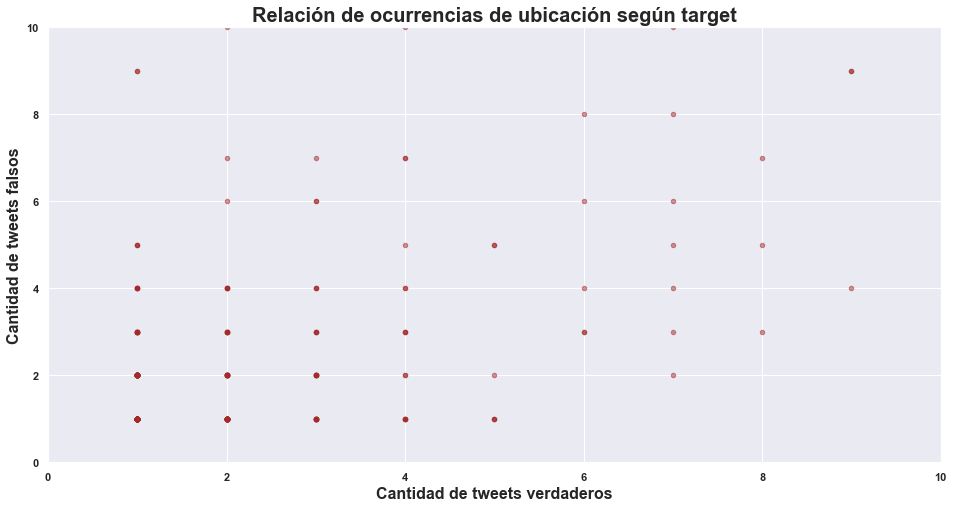

In [61]:
merge_locations.loc[(merge_locations['cantidad_verdaderos'] != 0) & (merge_locations['cantidad_falsos'] != 0)]\
                .plot.scatter('cantidad_verdaderos','cantidad_falsos',c='Brown',alpha=0.5,figsize=(16,8))

ax=plt.gca()

plt.xlim(0, 10)
plt.ylim(0, 10)

plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.title('Relación de ocurrencias de ubicación según target', fontsize=20,weight='bold')
plt.ylabel('Cantidad de tweets falsos', fontsize=16,weight='bold')
plt.xlabel('Cantidad de tweets verdaderos', fontsize=16,weight='bold');

Observamos que la relación entre la cantidad de tweets es similar en cada target y que hay pocos outliners dandole más valor a las repeticiones de un target en particular.

## Análisis de la cantidad de palabras de los tweets<a id='link_4'></a>

In [62]:
train_df['word_count'] = train_df['text'].str.count(' ') + 1
train_df['not_target'] = 0
train_df.loc[train_df['target']==0,'not_target'] = 1

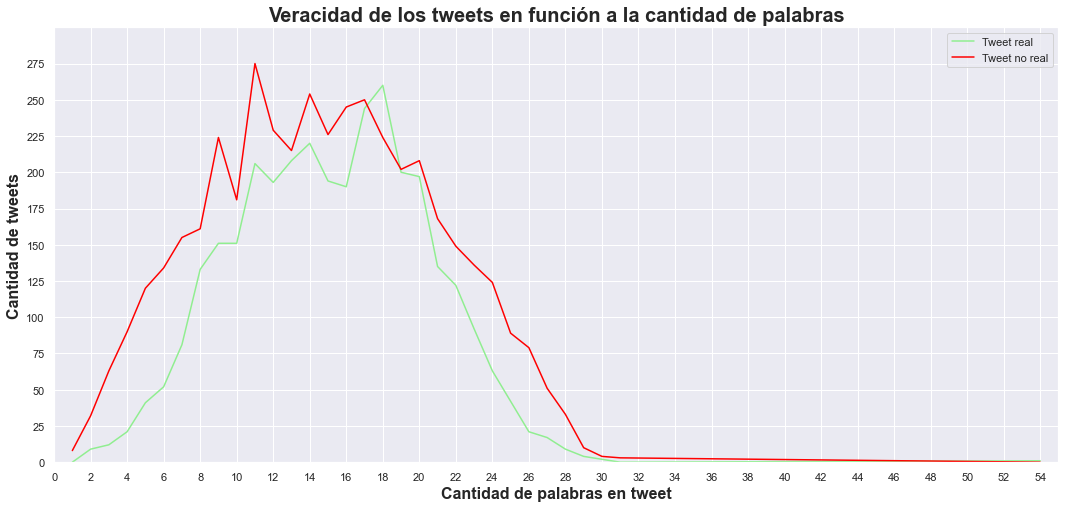

In [63]:
df = train_df.groupby('word_count').agg({'target':'sum','not_target':'sum'}).reset_index()

plt.figure(figsize=(18,8))
ax = sns.lineplot(x='word_count',y='target',data=df,color="lightgreen", label='Tweet real')
ax = sns.lineplot(x='word_count',y='not_target',data=df,color="red", label='Tweet no real')

ax.set_ylim(0,300)
ax.set_yticks(range(0,300,25))
ax.set_xlim(0,55)
ax.set_xticks(range(0,55,2))

ax.set_title('Veracidad de los tweets en función a la cantidad de palabras', fontsize=20,weight='bold')
ax.set_xlabel('Cantidad de palabras en tweet',fontsize=16,weight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16,weight='bold');

## Análisis de la longitud de los tweets<a id='link_5'></a>

In [64]:
train_df['longitud_del_tweet'] = train_df['text'].str.len()

Analizamos las estadísticas de la longitud en los tweets verdaderos.

In [65]:
train_df[train_df['target']]['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,3271.0,108.567105,29.571533,14.0,88.0,115.0,136.0,163.0


Analizamos las estadísticas de la longitud en los tweets falsos.

In [66]:
train_df[~train_df['target']]['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,4342.0,96.106633,36.183348,7.0,68.0,101.0,130.0,163.0


In [67]:
train_df = train_df.astype({'longitud_del_tweet':np.uint8})

Realizamos un gráfico para poder visualizar mejor las estadísticas de la longitud de los tweets según su target.

Text(0, 0.5, 'Longitud')

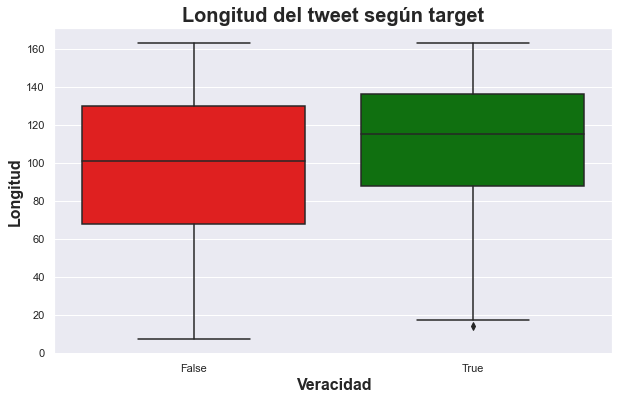

In [68]:
plt.figure(figsize=(10,6))

g = sns.boxplot(x="target",y="longitud_del_tweet", data=train_df,palette=['red','green'])

g.set_title("Longitud del tweet según target", fontsize=20, fontweight='bold')
g.set_xlabel("Veracidad", fontsize=16, fontweight='bold')
g.set_ylabel("Longitud",fontsize=16, fontweight='bold')

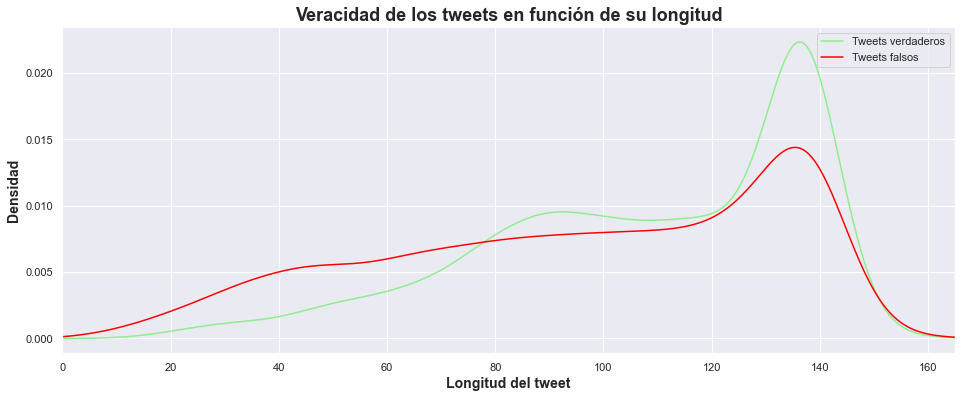

In [69]:
fig= plt.figure()
ax = fig.add_subplot(111)

plt.title('Veracidad de los tweets en función de su longitud',fontsize=18,fontweight='bold')

train_df[train_df['target']]['longitud_del_tweet'].plot.kde(color='lightgreen', figsize=(16, 6), label = 'Tweets verdaderos')
train_df[~train_df['target']]['longitud_del_tweet'].plot.kde(color='red', ax=ax, figsize=(16, 6), label = 'Tweets falsos')

ax.set_xlabel('Longitud del tweet', fontsize=14, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=14, fontweight='bold')

ax.set_xlim(0, 165) #Seteamos los límites del eje x conociendo el valor máximo y mínimo de la longitud de los tweets.
ax.legend()

plt.show()

En está visualización podemos observar que los tweets que tienen una longitud menor a 80 caracteres son en su mayoría falsos, mientras que los que tienen una longitud superior tienden a ser verdaderos. Tambíen podemos ver que la longitud de los tweets tiene un pico llegando a los 140 caracteres, lo cuál tiene sentido considerando las limitaciones que la plataforma solía tener respecto a la longitud de los mismos.

## Covarianza y Correlación<a id='link_6'></a>

In [70]:
train_df['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,7613.0,101.460397,34.063901,7.0,78.0,107.0,134.0,163.0


Vamos a analizar más en detalle que va sucediendo a medida que la longitud crece; que sucede con el target, es "más real" o no el tweet?<br>
Creamos unas categorías segun lo visto anteriormente donde de todas las longitudes el 25% promedio esta en 78, el 50% en 107 y así... la idea de estas categorías es agrupar rangos entre 0 a 25 , 25 a 50 , 50 a 75 y 75 a 100 segun estas medidas obtenidas.

In [71]:
train_df.loc[train_df['longitud_del_tweet']<78.0,'Categ']="0 a 25"
train_df.loc[train_df['longitud_del_tweet']>=78.0,'Categ']="25 a 50"
train_df.loc[train_df['longitud_del_tweet']>=107.0,'Categ']= "50 a 75"
train_df.loc[train_df['longitud_del_tweet']>=134.0,'Categ']= "75 a 100"

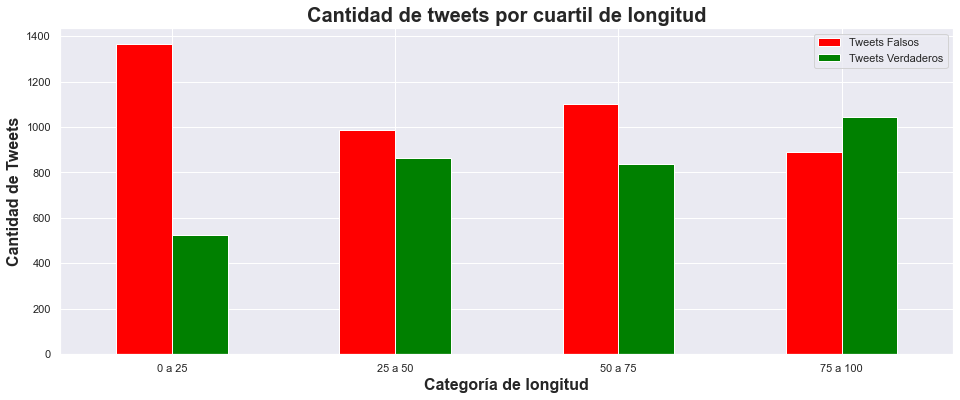

In [72]:
df_aux = train_df.groupby(['Categ','target'])['id'].count().unstack()
df_aux.columns = ['Tweets Falsos','Tweets Verdaderos']
df_aux.plot.bar(figsize=(16,6), color=('red','green'));
plt.xticks(rotation=0)

plt.title('Cantidad de tweets por cuartil de longitud', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');
plt.xlabel('Categoría de longitud', fontsize=16,weight='bold');

Podemos ver que a una longitud menor es más probable que sea un tweet falso y que cuanto más largo sea el tweet mayor su probabilidad de ser real.<br>
Ahora vamos a analizar cual es la covarianza y correlacion entre estas categorias creadas en base a su longitud (como largo de la cadena) vs target.

In [73]:
df_aux = train_df
df_aux['Categ_A'] = np.where(df_aux['Categ']=="0 a 25",1,0)
df_aux['Categ_B'] = np.where(df_aux['Categ']=="25 a 50",1,0)
df_aux['Categ_C'] = np.where(df_aux['Categ']=="50 a 75",1,0)
df_aux['Categ_D'] = np.where(df_aux['Categ']=="75 a 100",1,0)

In [74]:
df_aux[['Categ_A','Categ_B','Categ_C','Categ_D','longitud_del_tweet','target']].corr()

,Categ_A,Categ_B,Categ_C,Categ_D,longitud_del_tweet,target
Categ_A,1.000000,-0.326175,-0.335712,-0.335480,-0.819629,-0.176783
Categ_B,-0.326175,1.000000,-0.331108,-0.330878,-0.156706,0.042566
Categ_C,-0.335712,-0.331108,1.000000,-0.340553,0.333333,0.002808
Categ_D,-0.335480,-0.330878,-0.340553,1.000000,0.634870,0.130750
longitud_del_tweet,-0.819629,-0.156706,0.333333,0.634870,1.000000,0.181091
target,-0.176783,0.042566,0.002808,0.130750,0.181091,1.000000


Podemos ver como aumenta la correlacion un poco a medida que la logitud aumenta, pero esto no nos indica si aumenta según si es o no real.

## Análisis de menciones<a id='link_7'></a>

Vamos a analizar la naturaleza de los tweets en base a si se realiza alguna mención en el mismo o no.

In [75]:
train_df['tiene_menciones'] = train_df['text'].str.contains('@')
train_df['tiene_menciones'].value_counts()

False    5574
True     2039
Name: tiene_menciones, dtype: int64

Podemos ver que aproximadamente en el 26.7% de los tweets se realizan menciones a otro usuario.

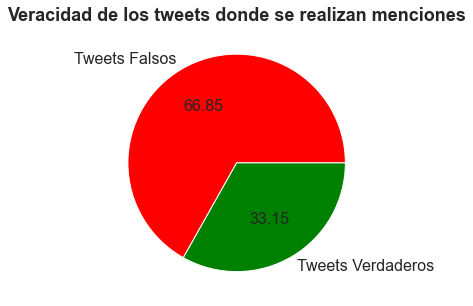

In [76]:
train_df.loc[train_df['tiene_menciones']]['target'].value_counts().plot.pie(labels=['Tweets Falsos','Tweets Verdaderos'],\
                                                figsize=(5,5),autopct='%.2f', fontsize=16,colors=('red','green'))

plt.ylabel('');
plt.title('Veracidad de los tweets donde se realizan menciones',fontsize=18,weight='bold');

Podemos ver que en 2/3 de los tweets en donde se realiza alguna mención, el tweet resulta ser falso.

## Análisis de "tweets expresivos"<a id='link_8'></a>

Consideramos como "tweet expresivo" a los tweets en donde se utiliza múltiples signos de exclamación o interrogación consecutivos.

In [77]:
train_df['es_expresivo'] = (train_df['text'].str.contains('\!\!') | train_df['text'].str.contains('\?\?'))
train_df['es_expresivo'].value_counts()

False    6972
True      641
Name: es_expresivo, dtype: int64

Vemos que solo en **641** registros se usan signos de exclamación o interrogación consecutivos, menos del 10% del set de datos.

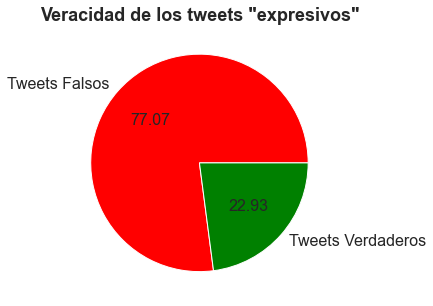

In [78]:
train_df.loc[train_df['es_expresivo']]['target'].value_counts().plot.pie(labels=['Tweets Falsos','Tweets Verdaderos'],\
                                                figsize=(5,5),autopct='%.2f', fontsize=16,colors=('red','green'))

plt.ylabel('');
plt.title('Veracidad de los tweets "expresivos"',fontsize=18,weight='bold');

Como podría esperarse, los tweets en donde se utilizan signos de puntuación de manera exagerada, en general para resaltar una emoción del usuario, no suelen ser sobre noticias reales.

### Hay algún registro que el <i><b>text</b></i> NO contenga la <i><b>keyword</b></i>?<a id='link_9'></a>

In [79]:
def f_aux(row):
  if str(row['keyword']).lower() in str(row['text']).lower():
    return True
  return False

train_df['contiene_key'] = train_df.loc[~train_df['keyword'].isnull()].apply(f_aux,axis=1)

In [80]:
train_df['contiene_key'].value_counts()

True     6700
False     852
Name: contiene_key, dtype: int64

In [81]:
train_df.loc[train_df['contiene_key']==False].head(10)[['keyword','text']]

,keyword,text
32,ablaze,We always try to bring the heavy. #metal #RT h...
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
45,ablaze,I gained 3 followers in the last week. You? Kn...
48,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
49,ablaze,First night with retainers in. It's quite weir...
52,ablaze,SANTA CRUZ ÂÃÃ Head of the St Elizabeth Pol...
54,ablaze,Noches El-Bestia '@Alexis_Sanchez: happy to se...
83,accident,#TruckCrash Overturns On #FortWorth Interstate...
103,aftershock,'The man who can drive himself further once th...
105,aftershock,'There is no victory at bargain basement price...


In [82]:
train_df.loc[train_df['contiene_key']==False]['target'].value_counts()

False    500
True     352
Name: target, dtype: int64

Podemos observar que de todos los datos que tienen keyword válido, <b>6700</b> 
son los que contienen exactamente la palabra. Los otros <b>852</b> son interpretaciones del tweet o ruido. No se considera que vale la pena quitar 852 registros por la posibilidad de que la mayoria sean o no ruido.

## Análisis de hashtags<a id='link_10'></a>

Armamos una lista con los hashtag que contiene el tweet.

In [83]:
train_df['cantidad_de_hashtags'] = train_df['text'].str.count('#')

In [84]:
import re
def split_hashtag(hashtag):
    return re.findall(r"#(\w+)",hashtag)

train_df['hashtags'] = train_df['text'].apply(split_hashtag)

In [85]:
train_df['cantidad_de_hashtags'].value_counts()

0     5852
1      964
2      405
3      208
4       83
5       41
6       26
10      10
7        8
8        8
13       4
11       2
9        2
Name: cantidad_de_hashtags, dtype: int64

In [86]:
df = train_df[['hashtags']].explode('hashtags').dropna()
top20_hashtags = df['hashtags'].value_counts().head(40).to_list()

top20_hashtags = [str(hashtag).lower() for hashtag in top20_hashtags]

Vamos a ver los hashtags que más aparecen en los tweets.<br>
Para esto, vamos a hacer uso de lo que sería una normalizacion de palabras para poder "agrupar" de mejor forma, por ejemplo:
* rocks : rock
* corpora : corpus
* better : good

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FF633NG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FF633NG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FF633NG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


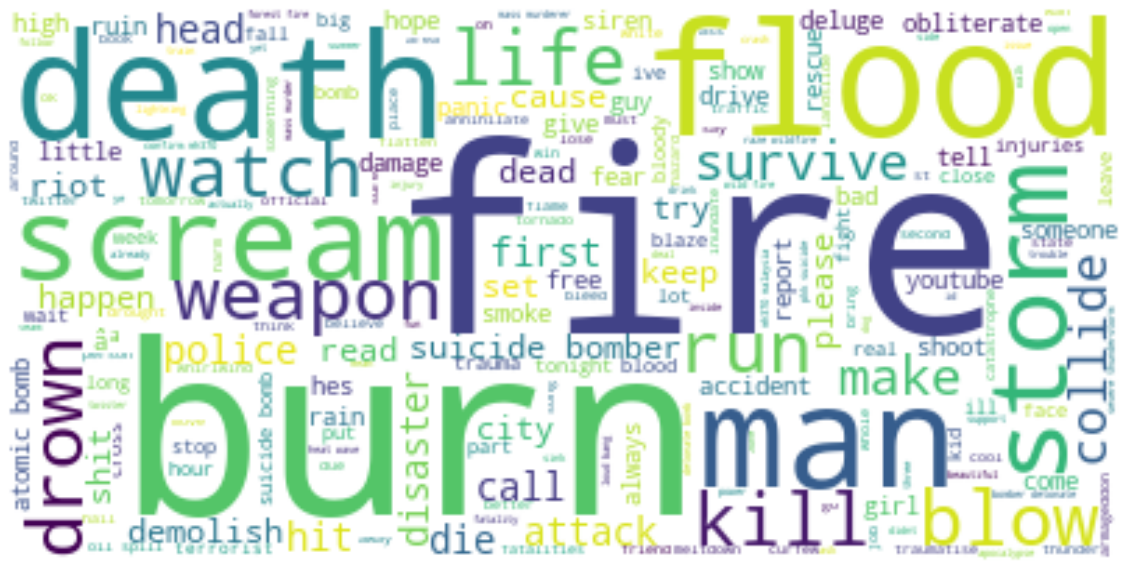

In [87]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

df=train_df.copy()

#vamos a limpiar un poco el tweet
pattern_exclude = '(one|dont|cant|would|im|people|go|make|time|love|amp|get|house|update|talk'+\
                  '|want|today|know|say|us|day|crush|see|back|think|look|rigth|remember|car'+\
                  '|thing|let|still|lol|much|thank|take|way|youre|road|another|really|save'+\
                  '|play|even|theres|everyone|feel|year|work|check|two|great|ing|like|sink'+\
                  '|every|build|youtuve|video|n|home|body|bag|photo|stay|game|start|gt|fuck|help'+\
                  '|best|well|california|end|live|e|rt|wreck|plan|full|may|ies|u|could|many|last'+\
                  '|find|service|leave|collapse|world|war|destroy|wound|break|right|hear|school)+'

def filter_words(tweet):
    tweet = re.sub(r'(\b[\w]+:\/\/[\w -\?&;#~=\.\/@]+[\w\/])', ' ', tweet)
    tweet = re.sub(r'\'', '', tweet)
    return re.sub(r'[www.]*[A-z]+.(com|gov|edu|net|mil|org|io|int)+', ' ', tweet)

def text_to_blob(tweet):
    tweet_blob = TextBlob(str(tweet))
    return ' '.join(tweet_blob.words)


def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            word_aux = word.lower().strip()
            if re.match(pattern_exclude,
                        word_aux):
                continue
            normalized_text = lem.lemmatize(word_aux,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet

def clean(tweet):
    tweet_list = [word for word in (text_to_blob(filter_words(tweet))).split()]
    clean_tokens = [tkn for tkn in tweet_list if re.match(r'[A-z]+', tkn)]
    clean_s = ' '.join(clean_tokens)
    l_aux = normalization(clean_s.split())
    return ' '.join([word for word in l_aux if word not in stopwords.words('english')])

df['clean_text'] = df['text'].apply(clean)

text = df['clean_text'].str.split(' ').to_frame().explode('clean_text')['clean_text'].str.cat(sep=' ').lower()

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos ver algunas palabras que podrian resultar impotantes como:
* FIRE
* POLICE
* WEAPON
* EMERGENCY
* HELP
* DEAD
* DAMAGE
* SMOKE
* SUICIDE
* BOMBER
* ATTACK
* FEAR
* CAUSE
* MILITARY

In [88]:
def f_aux(hashtags):
    for hashtag in hashtags:
        if str(hashtag).lower() in ['fire','police','weapon','emergency','help','dead','damage','smoke',
              'suicide','bomber','military','attack','blood','accident','fear','cause']:
            return True
    return False
train_df['hashtag_importante'] = train_df['hashtags'].apply(f_aux)

In [89]:
train_df.loc[train_df['hashtag_importante']==True]['target'].value_counts()

False    11
True     10
Name: target, dtype: int64

No encontramos nada con hashtags y estas palabras, pero veamos los textos que contengan estas que sucede.

In [90]:
def f_aux(texto):
    for w in ['fire','police','weapon','emergency','help','dead','damage','smoke',
              'suicide','bomber','military','attack','blood','accident','fear','cause']:
        if w in str(texto).lower():
            return True
    return False

train_df['texto_importante'] = train_df['text'].apply(f_aux)

In [91]:
train_df.loc[train_df['texto_importante']==True]['target'].value_counts()

True     1006
False     718
Name: target, dtype: int64

In [92]:
train_df.shape

(7613, 20)

Igualmente como vimos al inicio, **5852** de los tweets no tienen hashtag, lo que nos deja el set bastante reducido de **1761** registros.

Veamos puntualmente estas palabras que se remarcan en el gráfico que sucede.

In [93]:
df['clean_text'].str.split().to_frame().explode('clean_text')['clean_text'].value_counts(ascending=False).head(15)

fire        354
bomb        228
burn        180
kill        168
flood       164
disaster    152
crash       150
attack      149
police      137
train       127
storm       125
watch       118
suicide     114
scream      112
man         110
Name: clean_text, dtype: int64

Cuántas de estas son keyword ? Qué sucede con estas palabras y el target?

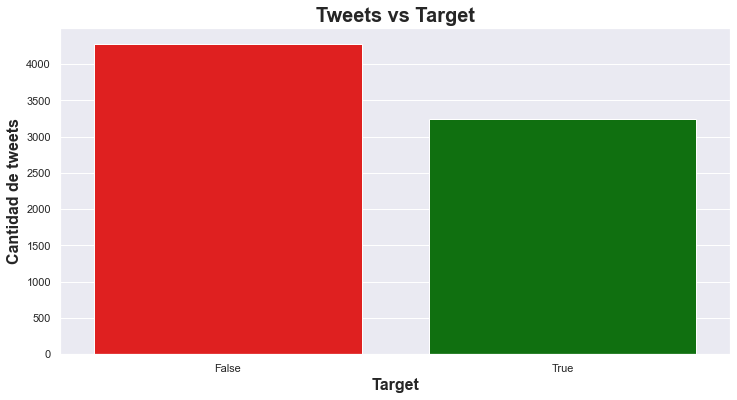

In [94]:
important_words = df['clean_text'].str.split().to_frame().explode('clean_text')['clean_text'].value_counts(ascending=False)
important_words = important_words.reset_index()['index'].to_list()

def f_aux(tweet):
    for word in important_words:
        if word in tweet:
            return True
    return False

df['important_word_match_text'] = df['clean_text'].apply(f_aux)
df_aux = df.loc[df['important_word_match_text']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Tweets vs Target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

plt.show()

Esto con todas las palabras filtradas no nos sirve de mucho, veamos con el top15 que sucede.

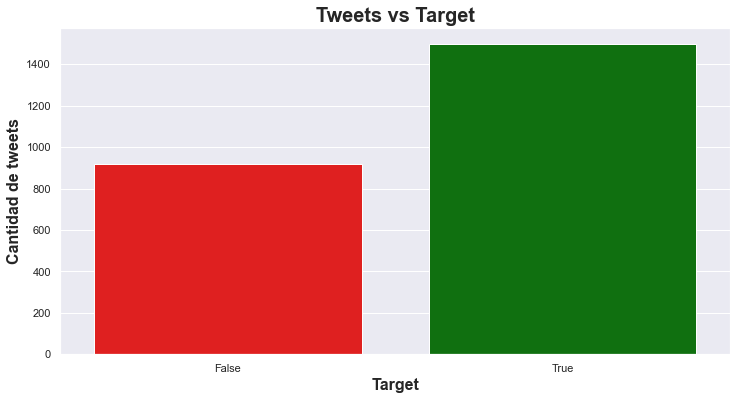

In [95]:
important_words = df['clean_text'].str.split().to_frame().explode('clean_text')['clean_text'].value_counts(ascending=False).head(15)
important_words = important_words.reset_index()['index'].to_list()

def f_aux(tweet):
    for word in important_words:
        if word in tweet:
            return True
    return False

df['important_word_match_text'] = df['clean_text'].apply(f_aux)
df_aux = df.loc[df['important_word_match_text']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Tweets vs Target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

plt.show()

Podemos observar que con el top 15 de palabras importantes vemos mayor tendencia a que sea un tweet veraz!

Ahora, de estos registros con match de palabras importantes hay alguna coincidencia con el keyword? Si está vacío se lo podría completar?

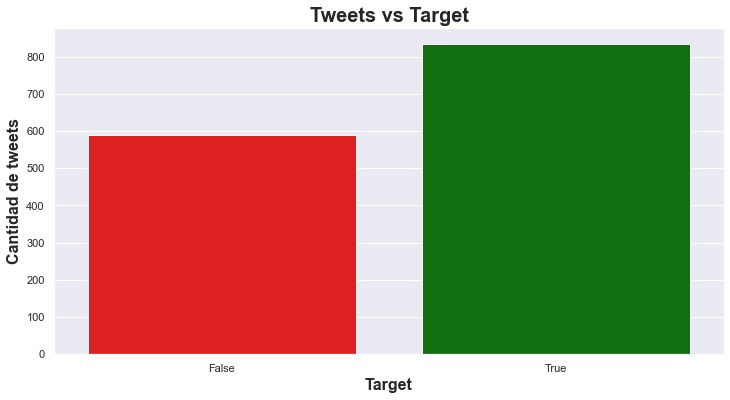

In [96]:
def f_aux(keyword):
    for word in important_words:
        if word in str(keyword):
            return True
    return False

df['important_word_match_keyword'] = df['keyword'].apply(f_aux)
df_aux = df.loc[df['important_word_match_keyword']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Tweets vs Target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

plt.show()

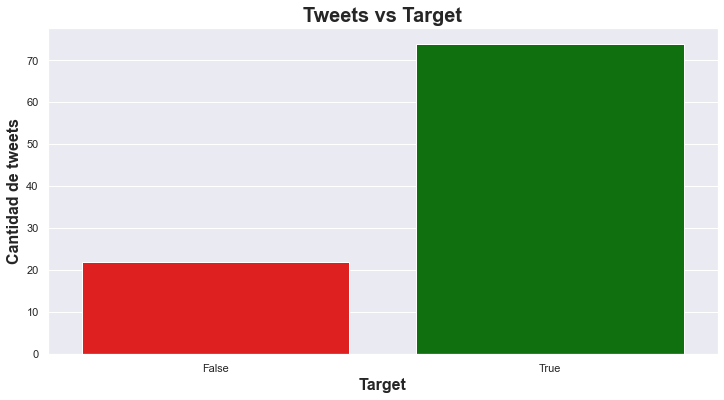

In [97]:
def f_aux(hashtags):
    for word in important_words:
        if any(word in ele for ele in hashtags):
            return True
    return False

df['important_word_match_hashtag'] = df['hashtags'].apply(f_aux)
df_aux = df.loc[df['important_word_match_hashtag']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Tweets vs Target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

plt.show()

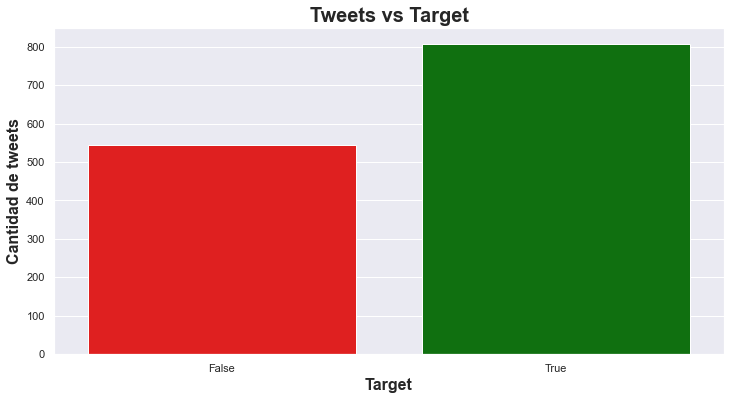

In [98]:
df_aux = df.loc[(df['important_word_match_text']==True)&(df['important_word_match_keyword']==True)]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Tweets vs Target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

plt.show()

No son demasiados los registros que se esan analizando, son 1400 aproximadamente, pero nos da un indicio que con estas palabras hay mayor tendencia a que el tweet sea real.

## Análisis de links<a id='link_11'></a>

Veamos si hay alguna relación entre los tweets que tienen links y su veracidad.

In [99]:
train_df['text'].str.contains('http').value_counts()

True     3971
False    3642
Name: text, dtype: int64

Podemos ver que un poco más de la mitad (aproximadamente el **52,2%**) de los tweets tienen links en el texto.

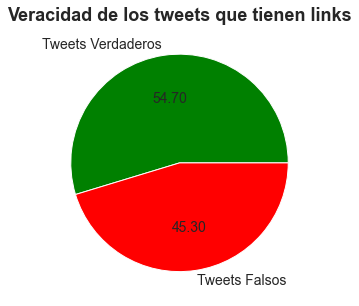

In [100]:
train_df.loc[train_df['text'].str.contains('http')]['target'].value_counts().plot.pie(labels=['Tweets Verdaderos','Tweets Falsos'],\
                                                figsize=(5,5),autopct='%.2f', fontsize=14,colors=('green','red'))

plt.ylabel('');
plt.title('Veracidad de los tweets que tienen links',fontsize=18,weight='bold');

No parece que el hecho de que un tweet tenga un link o no sea determinante para la veracidad del mismo. Vamos a analizar más profundamente los links que aparecen en los tweets para poder determinar si hay links que se repitan en muchos casos.

In [101]:
import re
def split_links(text):
    return re.findall(r"(http[^ ]+)",text)

train_df['links'] = train_df['text'].apply(split_links)

In [102]:
links_df = train_df[['links','text','target']].explode('links').dropna()
links_df.head()

,links,text,target
31,http://t.co/lHYXEOHY6C,@bbcmtd Wholesale Markets ablaze http://t.co/l...,True
32,http://t.co/YAo1e0xngw,We always try to bring the heavy. #metal #RT h...,False
33,http://t.co/2nndBGwyEi,#AFRICANBAZE: Breaking news:Nigeria flag set a...,True
35,http://t.co/qqsmshaJ3N,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,False
37,http://t.co/3ImaomknnA,INEC Office in Abia Set Ablaze - http://t.co/3...,True


In [103]:
links_df['links'].value_counts()[links_df['links'].value_counts() > 1]

http://t.co/qew4c5M1xd    9
http://t.co/q2eBlOKeVE    6
http://t.co/KSAwlYuX02    6
http://t.co/eNCmhz6y34    6
http://t.co/vVPLFQv58P    5
                         ..
http://t.co/zDtoyd8EbJ    2
http://t.co/YDUiXEfIpE    2
http://t.co/sAF9MoSkSN    2
http://t.co/M5KxLPKFA1    2
http://t.co/cgf61fPmR0    2
Name: links, Length: 72, dtype: int64

Podemos ver que hay 72 links que aparecen en más de un tweet, el más recurrente con 9 tweets; por lo que tampoco parece que haya algún caso de un "link que se repita en gran cantidad de tweets falsos o verdaderos" que nos sirva como indicador.

In [104]:
links_grouped = links_df.groupby(['links','target']).agg({'target':'count'}).rename(columns={'target':'cantidad_tweets'}).reset_index()
links_grouped.head()

,links,target,cantidad_tweets
0,http://t.co/007Npen6LG,True,1
1,http://t.co/00cY9vXEFF,False,1
2,http://t.co/02ELqLOpFk,True,1
3,http://t.co/03L7NwQDje,False,1
4,http://t.co/073izwX0lB,False,1


In [105]:
links_multitarget = links_grouped['links'].value_counts()[links_grouped['links'].value_counts() > 1].to_frame().index.to_list()
links_multitarget

['http://t.co/q2eBlOKeVE',
 'http://t.co/JlzK2HdeTG',
 'http://t.co/xpFmR368uF',
 'http://t.co/eNCmhz6y34',
 'https://t.co/moLL5vd8yD',
 'http://t.co/zujwUiomb3',
 'http://t.co/pyehwodWun',
 'http://t.co/vz1irH0Nmm',
 'http://t.co/cybKsXHF7d',
 'http://t.co/9NwAJLi9cr',
 'http://t.co/XsSgEdSbH4',
 'http://t.co/BbDpnj8XSx',
 'https://t.co/rqWuoy1fm4',
 'https://t.co/e8dl1lNCVu',
 'http://t.co/0wrATkA2jL',
 'http://t.co/aFMKcFn1TL',
 'http://t.co/YdEtWgRibk']

Vemos que hay links que aparecen tanto en tweets verdaderos como falsos. Vamos a analizar más en profundidad dichos links.

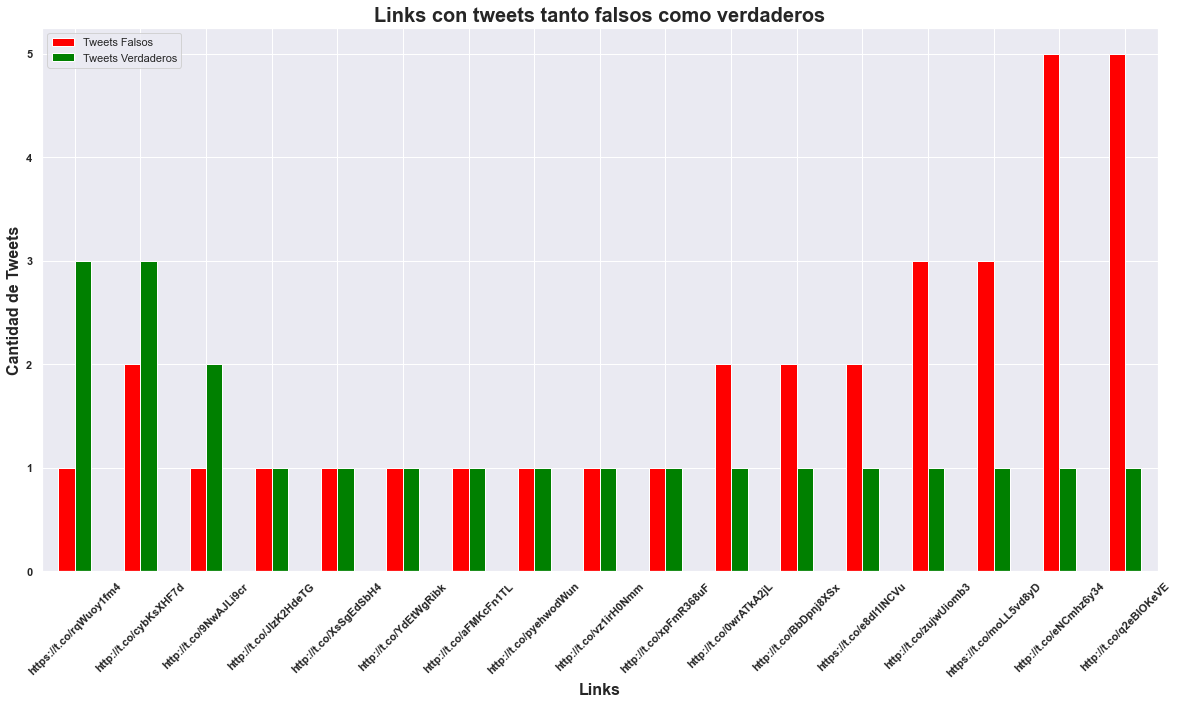

In [106]:
df_aux = links_df[links_df['links'].isin(links_multitarget)].groupby(['links','target'])['target'].count().unstack()

df_aux.columns = ['Tweets Falsos','Tweets Verdaderos']

df_aux.sort_values(['Tweets Verdaderos','Tweets Falsos'],ascending=[False,True]).plot.bar(figsize=(20,10),color=('red','green'));

plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.title('Links con tweets tanto falsos como verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Links', fontsize=16,weight='bold')
plt.xticks(rotation=45,weight='bold')

plt.show()

In [107]:
links_df.loc[links_df['links'].isin(links_multitarget)].sort_values(['links','target'])[['text','target']]

,text,target
4149,@dinallyhot Love what you picked! We're playin...,False
4168,@5hvzlaRadio Love what you picked! We're playi...,False
4143,@leedsrouge Love what you picked! We're playin...,True
3012,The answer my friend is yelling in the wind-my...,False
2997,When the answer my friend isn't blowing in the...,True
3021,Wall of noise is one thing - but a wall of dus...,True
5072,This is the natural and unavoidable consequenc...,False
5078,This is the natural and unavoidable consequenc...,False
5066,This is the natural and unavoidable consequenc...,True
4379,RT NotExplained: The only known image of infam...,False


Vemos que en la mayoría de los casos el tweet es casi idéntico más allá de que cambie el target. Por lo tanto, suponemos que el target de estos registros en donde varía la veracidad puede deberse a un error a la hora de clasificar estos tweets.